In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=8, color='darkgray', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=8, color='darkgray', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos confirmados COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [11]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
813092               2020-09-27           2020-09-25            2020-09-24   
813093               2020-09-27           2020-09-25            2020-09-25   
813094               2020-09-27           2020-09-25            2020-09-24   
813095               2020-09-27           2020-09-25            2020-09-24   
813096               2020-09-27           2020-09-24            2020-09-24   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                           2020-02-27            2020-03-13   
2                           2020-03-04            2020-03-19   
3                           2020-02-29            2020-03-15   
4                           2020-03-06            2020-03-26   
5                           2020-03-08            2020-03-23   
...                                ...                   ...   
813092                      2020-09-21                   NaT   
813093                      2020-09-23                   NaT   
813094                      2020-09-20                   NaT   
813095                      2020-09-23                   NaT   
813096                      2020-09-18                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
813092                    NaT                 Cali  Valle del Cauca      Leve   
813093                    NaT                 Cali  Valle del Cauca      Leve   
813094                    NaT              Palmira  Valle del Cauca      Leve   
813095                    NaT                 Cali  Valle del Cauca      Leve   
813096                    NaT                 Cali  Valle del Cauca      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M             Negro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
813092            Casa  ...                50 - 60    F               NaN   
813093            Casa  ...                30 - 40    M               NaN   
813094            Casa  ...                40 - 50    F               NaN   
813095            Casa  ...                40 - 50    F               NaN   
813096            Casa  ...                30 - 40    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - TOP 50: Casos activos VS Ciudad de ubicación (Estado)

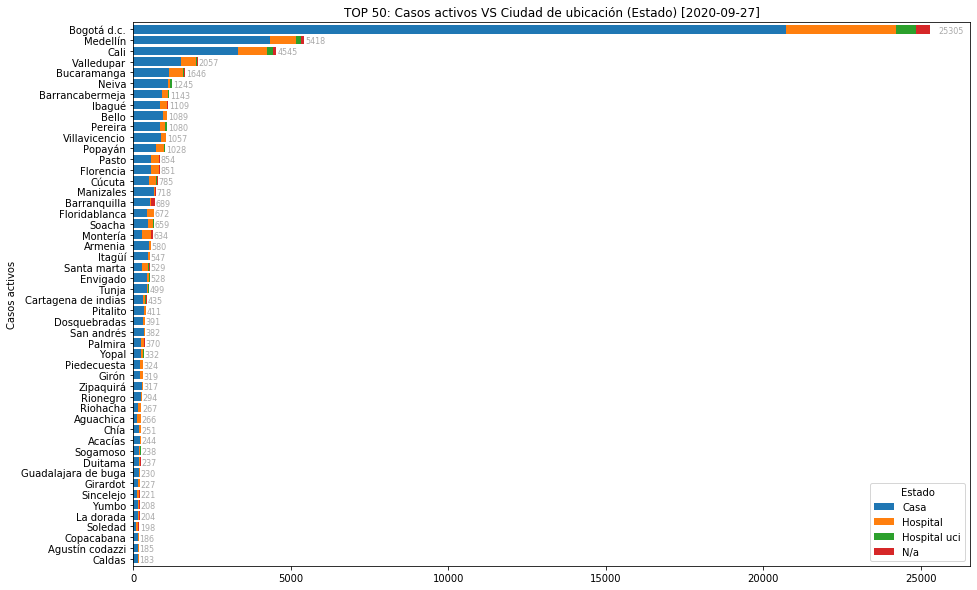

In [50]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'TOP 50: Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers_H(div)

In [13]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          20721.0    3486.0         640.0  458.0  25305.0
Medellín              4362.0     806.0         164.0   86.0   5418.0
Cali                  3323.0     921.0         194.0  107.0   4545.0
Valledupar            1536.0     468.0          38.0   15.0   2057.0
Bucaramanga           1137.0     447.0          42.0   20.0   1646.0
Neiva                 1118.0      65.0          53.0    9.0   1245.0
Barrancabermeja        911.0     207.0          17.0    8.0   1143.0
Ibagué                 840.0     224.0          18.0   27.0   1109.0
Bello                  946.0     116.0          17.0   10.0   1089.0
Pereira                866.0     162.0          42.0   10.0   1080.0
Villavicencio          897.0     134.0          11.0   15.0   1057.0
Popayán                736.0     242.0          35.0   15.0   1028.0
Pasto                  562.0     250.0          24.0   18.0    854.0
Florencia              578.0     245.0          14.0   14.0    851.0
Cúcuta                 510.0     229.0          34.0   12.0    785.0
Manizales              657.0      47.0           4.0   10.0    718.0
Barranquilla           547.0      25.0           2.0  115.0    689.0
Floridablanca          447.0     202.0          18.0    5.0    672.0
Soacha                 461.0     173.0          15.0   10.0    659.0
Montería               292.0     277.0          11.0   54.0    634.0
Armenia                516.0      61.0           2.0    1.0    580.0
Itagüí                 473.0      59.0           7.0    8.0    547.0
Santa marta            293.0     195.0          17.0   24.0    529.0
Envigado               455.0      60.0          10.0    3.0    528.0
Tunja                  430.0      59.0           4.0    6.0    499.0
Cartagena de indias    320.0      63.0          13.0   39.0    435.0
Pitalito               352.0      45.0           9.0    5.0    411.0
Dosquebradas           313.0      65.0          11.0    2.0    391.0
San andrés             355.0      24.0           2.0    1.0    382.0
Palmira                244.0     104.0          14.0    8.0    370.0
Yopal                  251.0      71.0           9.0    1.0    332.0
Piedecuesta            220.0      90.0          12.0    2.0    324.0
Girón                  207.0     102.0           6.0    4.0    319.0
Zipaquirá              285.0      23.0           5.0    4.0    317.0
Rionegro               240.0      47.0           4.0    3.0    294.0
Riohacha               163.0      92.0           6.0    6.0    267.0
Aguachica              113.0     143.0           9.0    1.0    266.0
Chía                   199.0      42.0           6.0    4.0    251.0
Acacías                213.0      25.0           3.0    3.0    244.0
Sogamoso               199.0      36.0           1.0    2.0    238.0
Duitama                203.0      28.0           2.0    4.0    237.0
Guadalajara de buga    179.0      47.0           2.0    2.0    230.0
Girardot               171.0      49.0           6.0    1.0    227.0
Sincelejo              112.0      85.0           6.0   18.0    221.0
Yumbo                  161.0      39.0           3.0    5.0    208.0
La dorada              158.0      40.0           4.0    2.0    204.0
Soledad                 98.0      49.0           7.0   44.0    198.0
Copacabana             169.0      14.0           1.0    2.0    186.0
Agustín codazzi        157.0      26.0           2.0    0.0    185.0
Caldas                 159.0      24.0           0.0    0.0    183.0

### - Casos activos VS Departamento (Estado)

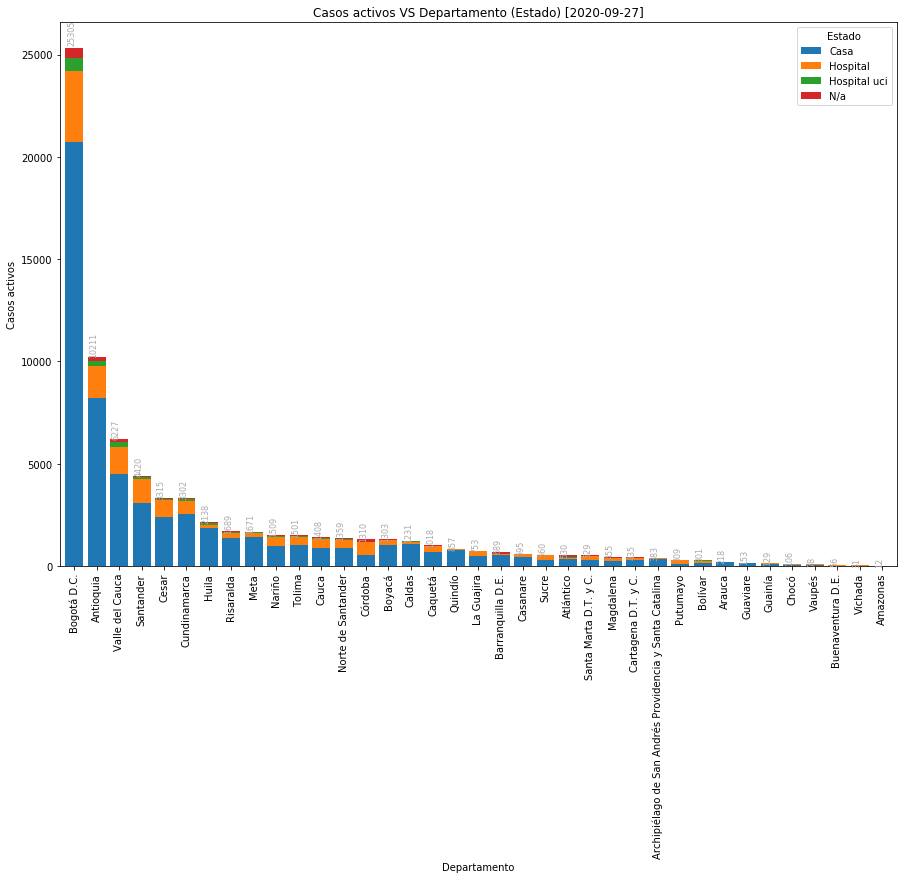

In [14]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [15]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         20721.0    3486.0   
Antioquia                                            8214.0    1576.0   
Valle del Cauca                                      4520.0    1322.0   
Santander                                            3092.0    1173.0   
Cesar                                                2399.0     828.0   
Cundinamarca                                         2542.0     640.0   
Huila                                                1862.0     167.0   
Risaralda                                            1349.0     271.0   
Meta                                                 1405.0     227.0   
Nariño                                                964.0     463.0   
Tolima                                               1042.0     388.0   
Cauca                                                 899.0     410.0   
Norte de Santander                                    872.0     387.0   
Córdoba                                               564.0     607.0   
Boyacá                                               1042.0     231.0   
Caldas                                               1064.0     130.0   
Caquetá                                               671.0     307.0   
Quindío                                               771.0      81.0   
La Guajira                                            501.0     217.0   
Barranquilla D.E.                                     547.0      25.0   
Casanare                                              465.0     110.0   
Sucre                                                 300.0     219.0   
Atlántico                                             327.0      88.0   
Santa Marta D.T. y C.                                 293.0     195.0   
Magdalena                                             229.0     172.0   
Cartagena D.T. y C.                                   320.0      63.0   
Archipiélago de San Andrés Providencia y Santa ...    355.0      25.0   
Putumayo                                              107.0     190.0   
Bolívar                                               164.0      93.0   
Arauca                                                193.0      20.0   
Guaviare                                              138.0       9.0   
Guainía                                               114.0      15.0   
Chocó                                                  41.0      49.0   
Vaupés                                                 62.0      14.0   
Buenaventura D.E.                                      22.0      23.0   
Vichada                                                26.0       4.0   
Amazonas                                                3.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                640.0  458.0   
Antioquia                                                  253.0  168.0   
Valle del Cauca                                            239.0  146.0   
Santander                                                  104.0   51.0   
Cesar                                                       60.0   28.0   
Cundinamarca                                                75.0   45.0   
Huila                                                       86.0   23.0   
Risaralda                                                   55.0   14.0   
Meta                                                        16.0   23.0   
Nariño                                                      41.0   41.0   
Tolima                                                      29.0   42.0   
Cauca                                                       68.0   31.0   
Norte de Santander                                          75.0   25.0   
Córdoba                    

### - Casos confirmados VS Departamento (Estado)

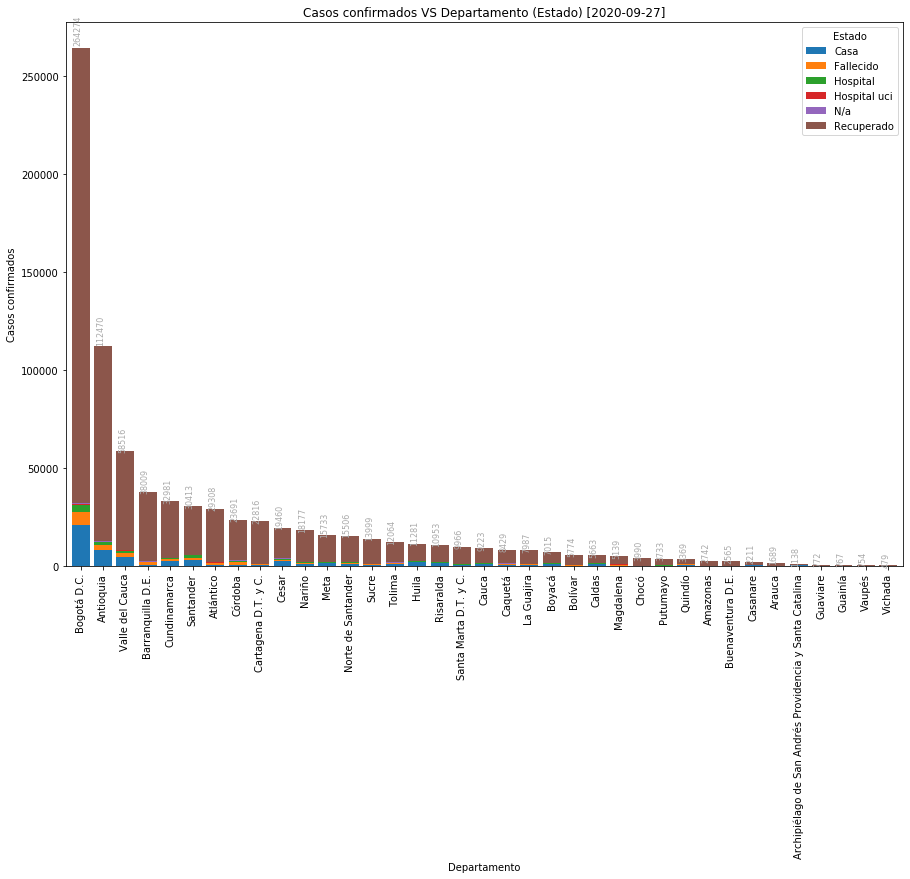

In [16]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [17]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         20721.0     6714.0   
Antioquia                                            8214.0     2337.0   
Valle del Cauca                                      4520.0     2052.0   
Barranquilla D.E.                                     547.0     1674.0   
Cundinamarca                                         2542.0      973.0   
Santander                                            3092.0     1271.0   
Atlántico                                             327.0     1388.0   
Córdoba                                               564.0     1526.0   
Cartagena D.T. y C.                                   320.0      544.0   
Cesar                                                2399.0      565.0   
Nariño                                                964.0      675.0   
Meta                                                 1405.0      404.0   
Norte de Santander                                    872.0      880.0   
Sucre                                                 300.0      575.0   
Tolima                                               1042.0      319.0   
Huila                                                1862.0      344.0   
Risaralda                                            1349.0      237.0   
Santa Marta D.T. y C.                                 293.0      434.0   
Cauca                                                 899.0      257.0   
Caquetá                                               671.0      296.0   
La Guajira                                            501.0      297.0   
Boyacá                                               1042.0      144.0   
Bolívar                                               164.0      222.0   
Caldas                                               1064.0      125.0   
Magdalena                                             229.0      388.0   
Chocó                                                  41.0      155.0   
Putumayo                                              107.0      169.0   
Quindío                                               771.0       96.0   
Amazonas                                                3.0      117.0   
Buenaventura D.E.                                      22.0      168.0   
Casanare                                              465.0       46.0   
Arauca                                                193.0       44.0   
Archipiélago de San Andrés Providencia y Santa ...    355.0       14.0   
Guaviare                                              138.0       13.0   
Guainía                                               114.0       12.0   
Vaupés                                                 62.0        9.0   
Vichada                                                26.0        4.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3486.0         640.0   
Antioquia                                             1576.0         253.0   
Valle del Cauca                                       1322.0         239.0   
Barranquilla D.E.                                       25.0           2.0   
Cundinamarca                                           640.0          75.0   
Santander                                             1173.0         104.0   
Atlántico                                               88.0          16.0   
Córdoba                                                607.0          22.0   
Cartagena D.T. y C.                                     63.0          13.0   
Cesar                                                  828.0          60.0   
Nariño                                                 463.0          41.0   
Meta                                                   227.0          16.0   
Norte de Santander   

### - Casos confirmados VS Departamento (Sexo)

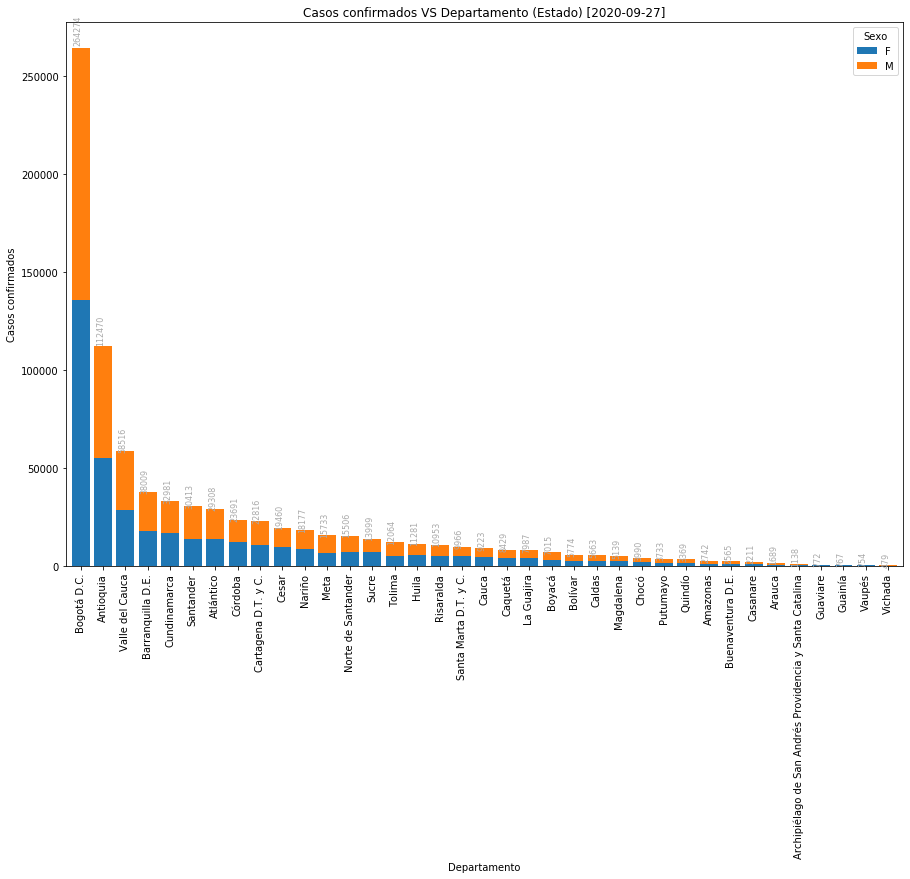

In [18]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [19]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         135708  128566  264274
Antioquia                                            54954   57516  112470
Valle del Cauca                                      28644   29872   58516
Barranquilla D.E.                                    18045   19964   38009
Cundinamarca                                         16785   16196   32981
Santander                                            13886   16527   30413
Atlántico                                            13897   15411   29308
Córdoba                                              12313   11378   23691
Cartagena D.T. y C.                                  10701   12115   22816
Cesar                                                 9586    9874   19460
Nariño                                                8884    9293   18177
Meta                                                  6495    9238   15733
Norte de Santander                                    7287    8219   15506
Sucre                                                 6945    7054   13999
Tolima                                                5042    7022   12064
Huila                                                 5432    5849   11281
Risaralda                                             5368    5585   10953
Santa Marta D.T. y C.                                 5011    4955    9966
Cauca                                                 4592    4631    9223
Caquetá                                               4148    4281    8429
La Guajira                                            4128    3859    7987
Boyacá                                                3330    3685    7015
Bolívar                                               2755    3019    5774
Caldas                                                2736    2927    5663
Magdalena                                             2621    2518    5139
Chocó                                                 1901    2089    3990
Putumayo                                              1736    1997    3733
Quindío                                               1633    1736    3369
Amazonas                                              1183    1559    2742
Buenaventura D.E.                                      947    1618    2565
Casanare                                               919    1292    2211
Arauca                                                 665    1024    1689
Archipiélago de San Andrés Providencia y Santa ...     588     550    1138
Guaviare                                               290     482     772
Guainía                                                362     405     767
Vaupés                                                 339     415     754
Vichada                                                176     303     479

### - Recuperados y Fallecidos VS Departamento

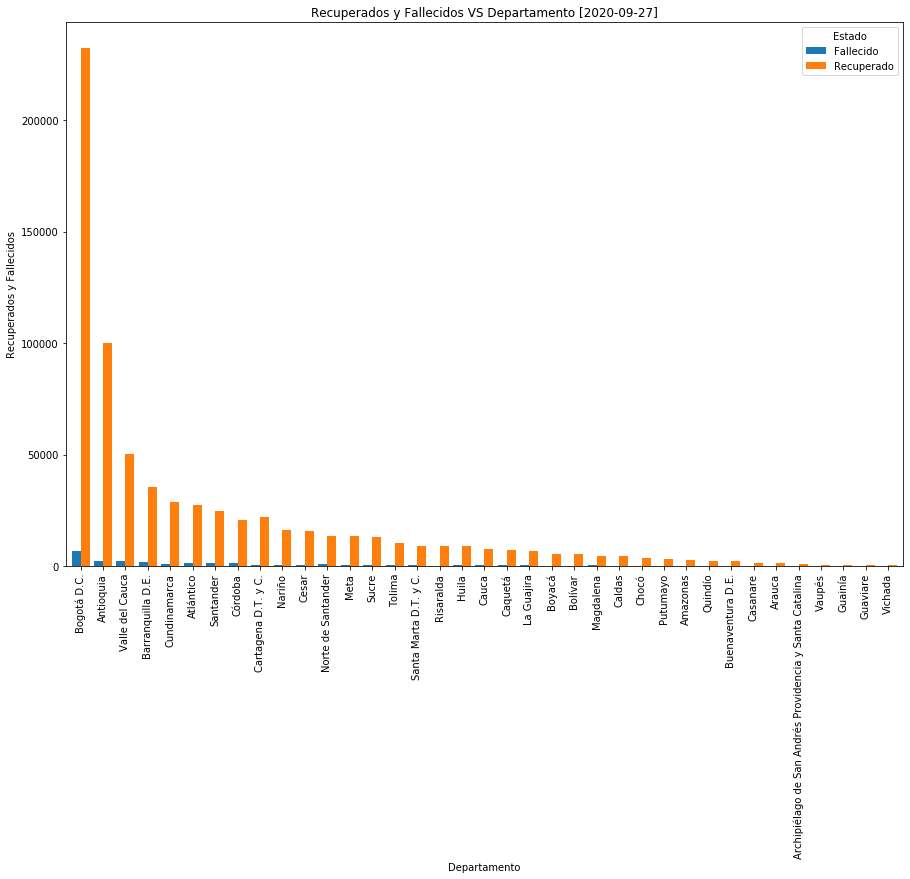

In [20]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [21]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            6714.0    232255.0
Antioquia                                              2337.0     99922.0
Valle del Cauca                                        2052.0     50237.0
Barranquilla D.E.                                      1674.0     35646.0
Cundinamarca                                            973.0     28706.0
Atlántico                                              1388.0     27390.0
Santander                                              1271.0     24722.0
Cartagena D.T. y C.                                     544.0     21837.0
Córdoba                                                1526.0     20855.0
Nariño                                                  675.0     15993.0
Cesar                                                   565.0     15580.0
Norte de Santander                                      880.0     13267.0
Meta                                                    404.0     13658.0
Sucre                                                   575.0     12864.0
Tolima                                                  319.0     10244.0
Santa Marta D.T. y C.                                   434.0      9003.0
Risaralda                                               237.0      9027.0
Huila                                                   344.0      8799.0
Cauca                                                   257.0      7558.0
Caquetá                                                 296.0      7115.0
La Guajira                                              297.0      6937.0
Boyacá                                                  144.0      5568.0
Bolívar                                                 222.0      5251.0
Magdalena                                               388.0      4296.0
Caldas                                                  125.0      4307.0
Chocó                                                   155.0      3729.0
Putumayo                                                169.0      3255.0
Amazonas                                                117.0      2613.0
Quindío                                                  96.0      2416.0
Buenaventura D.E.                                       168.0      2341.0
Casanare                                                 46.0      1570.0
Arauca                                                   44.0      1427.0
Archipiélago de San Andrés Providencia y Santa ...       14.0       741.0
Vaupés                                                    9.0       667.0
Guainía                                                  12.0       626.0
Guaviare                                                 13.0       606.0
Vichada                                                   4.0       444.0

* Fallecimientos relacionados al COVID-19.

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos confirmados COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

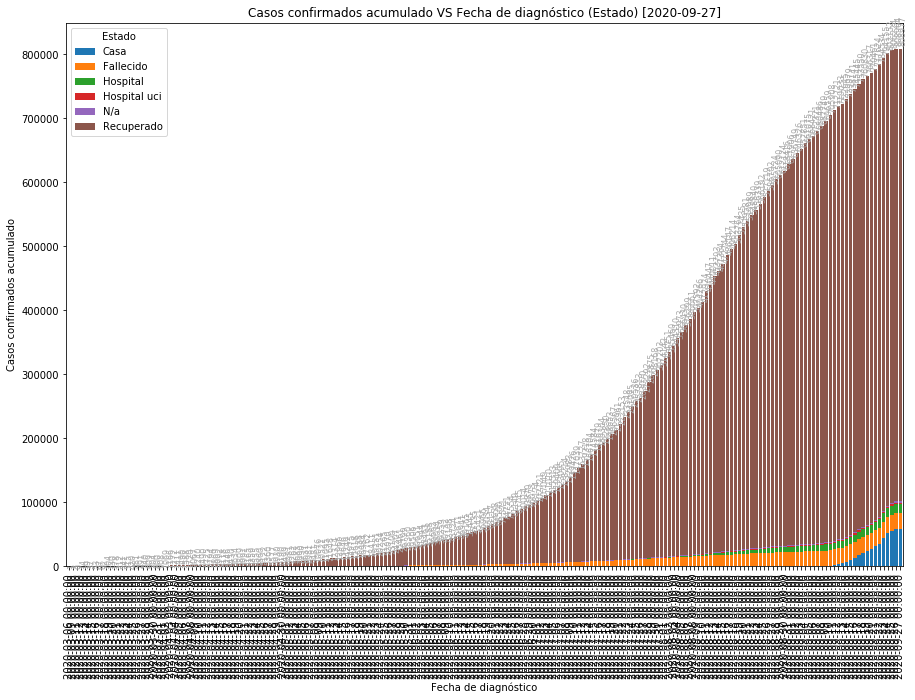

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                       
2020-09-27            58178.0    25275.0   14223.0        1969.0  1670.0   
2020-09-26            58169.0    25275.0   14219.0        1969.0  1670.0   
2020-09-25            55543.0    25275.0   14109.0        1965.0  1670.0   
2020-09-24            51585.0    25269.0   14001.0        1965.0  1670.0   
2020-09-23            44085.0    25212.0   13573.0        1956.0  1667.0   
2020-09-22            35420.0    25143.0   13152.0        1943.0  1659.0   
2020-09-21            31008.0    25072.0   12764.0        1915.0  1657.0   
2020-09-20            26790.0    25002.0   12501.0        1907.0  1654.0   
2020-09-19            24496.0    24957.0   12301.0        1891.0  1653.0   
2020-09-18            21385.0    24876.0   12082.0        1868.0  1651.0   
2020-09-17            17591.0    24780.0   11794.0        1824.0  1642.0   
2020-09-16            13376.0    24683.0   11486.0        1776.0  1632.0   
2020-09-15             9947.0    24555.0   11185.0        1730.0  1626.0   
2020-09-14             7286.0    24441.0   10977.0        1685.0  1620.0   
2020-09-13             4952.0    24308.0   10766.0        1635.0  1610.0   
2020-09-12             4030.0    24255.0   10643.0        1609.0  1605.0   
2020-09-11             2471.0    24120.0   10458.0        1581.0  1596.0   
2020-09-10              763.0    23979.0   10229.0        1544.0  1586.0   
2020-09-09              434.0    23816.0    9906.0        1502.0  1575.0   
2020-09-08              223.0    23638.0    9600.0        1473.0  1566.0   
2020-09-07              112.0    23487.0    9374.0        1431.0  1562.0   
2020-09-06              103.0    23314.0    9137.0        1403.0  1551.0   
2020-09-05              102.0    23228.0    9017.0        1388.0  1550.0   
2020-09-04               96.0    23058.0    8664.0        1357.0  1540.0   
2020-09-03               94.0    22890.0    8502.0        1311.0  1525.0   
2020-09-02               93.0    22738.0    8310.0        1284.0  1518.0   
2020-09-01               84.0    22428.0    8123.0        1246.0  1501.0   
2020-08-31               78.0    22230.0    7951.0        1216.0  1493.0   
2020-08-30               74.0    21992.0    7680.0        1179.0  1482.0   
2020-08-29               72.0    21838.0    7481.0        1152.0  1467.0   
2020-08-28               72.0    21649.0    7281.0        1131.0  1459.0   
2020-08-27               69.0    21389.0    6983.0        1080.0  1449.0   
2020-08-26               67.0    21139.0    6708.0        1050.0  1436.0   
2020-08-25               66.0    20829.0    6449.0        1019.0  1423.0   
2020-08-24               65.0    20554.0    6177.0         982.0  1409.0   
2020-08-23               57.0    20242.0    5883.0         955.0  1392.0   
2020-08-22               56.0    20054.0    5673.0         944.0  1383.0   
2020-08-21               56.0    19778.0    5321.0         933.0  1369.0   
2020-08-20               52.0    19474.0    4992.0         907.0  1345.0   
2020-08-19               47.0    19026.0    4562.0         869.0  1324.0   
2020-08-18               44.0    18666.0    4221.0         830.0  1303.0   
2020-08-17               41.0    18389.0    3992.0         815.0  1276.0   
2020-08-16               39.0    18171.0    3782.0         795.0  1260.0   
2020-08-15               35.0    17849.0    3469.0         770.0  1247.0   
2020-08-14               30.0    17531.0    3169.0         750.0  1235.0   
2020-08-13               27.0    17273.0    2992.0         737.0  1224.0   
2020-08-12               20.0    16935.0    2664.0         706.0  1202.0   
2020-08-11               17.0    16548.0    2373.0         680.0  1188.0   
2020-08-10               12.0    16111.0    1931.0         635.0  1159.0   
2020-08-09                8.0    15871.0    1696.0         615.0  1138.0   
2020-08-08                8.0    15631.0    1499

### - Casos confirmados VS Fecha de diagnóstico (Estado)

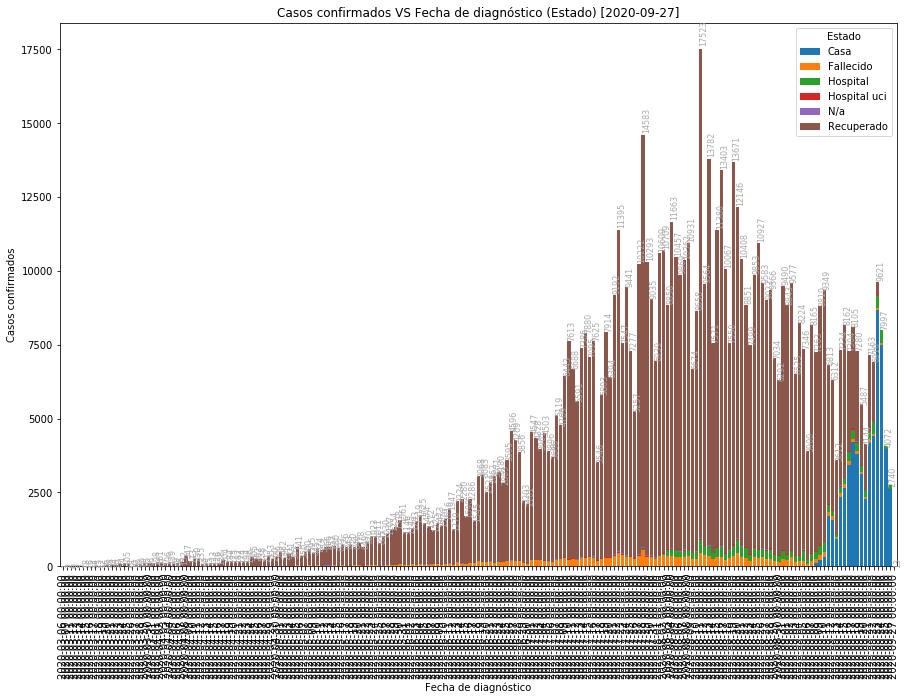

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-27               9.0        0.0       4.0           0.0   0.0   
2020-09-26            2626.0        0.0     110.0           4.0   0.0   
2020-09-25            3958.0        6.0     108.0           0.0   0.0   
2020-09-24            7500.0       57.0     428.0           9.0   3.0   
2020-09-23            8665.0       69.0     421.0          13.0   8.0   
2020-09-22            4412.0       71.0     388.0          28.0   2.0   
2020-09-21            4218.0       70.0     263.0           8.0   3.0   
2020-09-20            2294.0       45.0     200.0          16.0   1.0   
2020-09-19            3111.0       81.0     219.0          23.0   2.0   
2020-09-18            3794.0       96.0     288.0          44.0   9.0   
2020-09-17            4215.0       97.0     308.0          48.0  10.0   
2020-09-16            3429.0      128.0     301.0          46.0   6.0   
2020-09-15            2661.0      114.0     208.0          45.0   6.0   
2020-09-14            2334.0      133.0     211.0          50.0  10.0   
2020-09-13             922.0       53.0     123.0          26.0   5.0   
2020-09-12            1559.0      135.0     185.0          28.0   9.0   
2020-09-11            1708.0      141.0     229.0          37.0  10.0   
2020-09-10             329.0      163.0     323.0          42.0  11.0   
2020-09-09             211.0      178.0     306.0          29.0   9.0   
2020-09-08             111.0      151.0     226.0          42.0   4.0   
2020-09-07               9.0      173.0     237.0          28.0  11.0   
2020-09-06               1.0       86.0     120.0          15.0   1.0   
2020-09-05               6.0      170.0     353.0          31.0  10.0   
2020-09-04               2.0      168.0     162.0          46.0  15.0   
2020-09-03               1.0      152.0     192.0          27.0   7.0   
2020-09-02               9.0      310.0     187.0          38.0  17.0   
2020-09-01               6.0      198.0     172.0          30.0   8.0   
2020-08-31               4.0      238.0     271.0          37.0  11.0   
2020-08-30               2.0      154.0     199.0          27.0  15.0   
2020-08-29               0.0      189.0     200.0          21.0   8.0   
2020-08-28               3.0      260.0     298.0          51.0  10.0   
2020-08-27               2.0      250.0     275.0          30.0  13.0   
2020-08-26               1.0      310.0     259.0          31.0  13.0   
2020-08-25               1.0      275.0     272.0          37.0  14.0   
2020-08-24               8.0      312.0     294.0          27.0  17.0   
2020-08-23               1.0      188.0     210.0          11.0   9.0   
2020-08-22               0.0      276.0     352.0          11.0  14.0   
2020-08-21               4.0      304.0     329.0          26.0  24.0   
2020-08-20               5.0      448.0     430.0          38.0  21.0   
2020-08-19               3.0      360.0     341.0          39.0  21.0   
2020-08-18               3.0      277.0     229.0          15.0  27.0   
2020-08-17               2.0      218.0     210.0          20.0  16.0   
2020-08-16               4.0      322.0     313.0          25.0  13.0   
2020-08-15               5.0      318.0     300.0          20.0  12.0   
2020-08-14               3.0      258.0     177.0          13.0  11.0   
2020-08-13               7.0      338.0     328.0          31.0  22.0   
2020-08-12               3.0      387.0     291.0          26.0  14.0   
2020-08-11               5.0      437.0     442.0          45.0  29.0   
2020-08-10               4.0      240.0     235.0          20.0  21.0   
2020-08-09               0.0      240.0     197.0          20.0  10.0   
2020-08-08               0.0      346.0     192.0          33.0  21.0   
2020-08-07               0.0      305.0     215.0          42.0  24.0   
2020-08-06               0.0      301.0     171.0         

### - Casos confirmados VS Clasificación de edad (Estado)

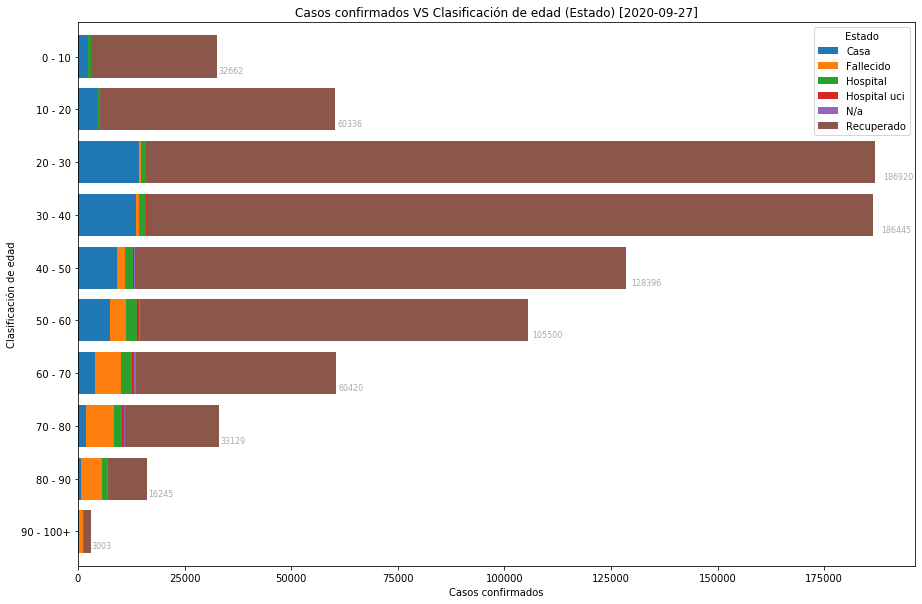

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  2277         42       721            47   38   
10 - 20                 4723         45       400            15   33   
20 - 30                14360        323      1176            74   69   
30 - 40                13521        811      1632           169   66   
40 - 50                 9176       1793      1917           256  122   
50 - 60                 7414       3746      2721           475  202   
60 - 70                 3902       6097      2639           499  372   
70 - 80                 1870       6590      1919           320  391   
80 - 90                  821       4924       962           105  329   
90 - 100+                136       1117       143            10   74   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      29537  
10 - 20                     55120  
20 - 30                    170918  
30 - 40                    170246  
40 - 50                    115132  
50 - 60                     90942  
60 - 70                     46911  
70 - 80                     22039  
80 - 90                      9104  
90 - 100+                    1523

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

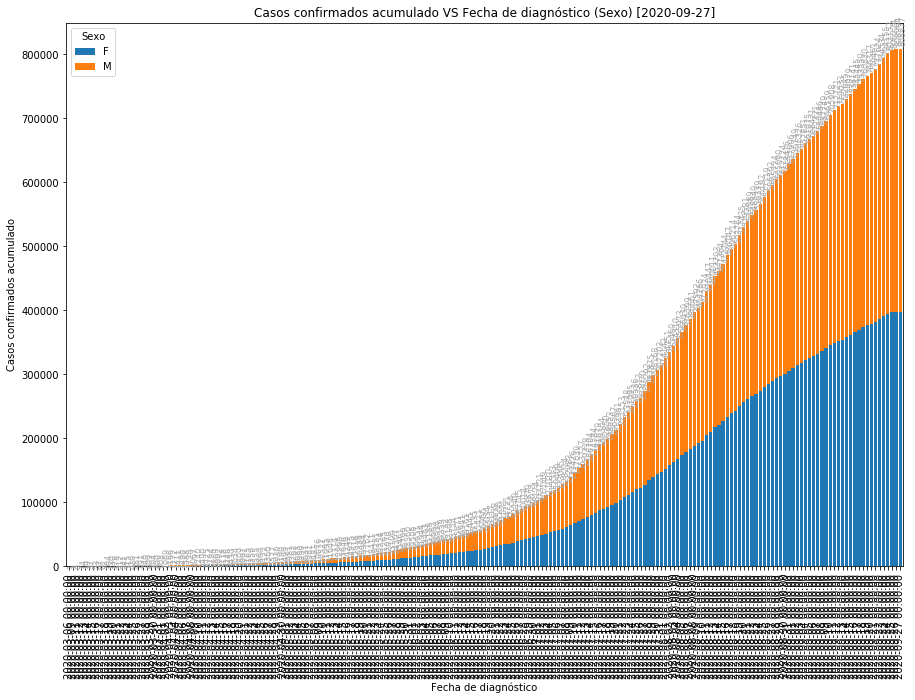

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-27            398085.0  410892.0
2020-09-26            398079.0  410885.0
2020-09-25            396685.0  409539.0
2020-09-24            394534.0  407618.0
2020-09-23            390475.0  403680.0
2020-09-22            385703.0  398831.0
2020-09-21            382157.0  395467.0
2020-09-20            378476.0  391985.0
2020-09-19            376300.0  390017.0
2020-09-18            373636.0  387194.0
2020-09-17            369848.0  383702.0
2020-09-16            365834.0  379611.0
2020-09-15            362100.0  376041.0
2020-09-14            357827.0  372152.0
2020-09-13            354075.0  368570.0
2020-09-12            352238.0  366795.0
2020-09-11            348909.0  363812.0
2020-09-10            345284.0  360624.0
2020-09-09            340510.0  356049.0
2020-09-08            336015.0  351734.0
2020-09-07            332310.0  348176.0
2020-09-06            328078.0  344243.0
2020-09-05            326079.0  342342.0
2020-09-04            322609.0  338466.0
2020-09-03            318189.0  334662.0
2020-09-02            314853.0  331473.0
2020-09-01            309966.0  326783.0
2020-08-31            305540.0  322366.0
2020-08-30            300538.0  317878.0
2020-08-29            297349.0  314775.0
2020-08-28            293785.0  311305.0
2020-08-27            289080.0  306644.0
2020-08-26            284527.0  302175.0
2020-08-25            279643.0  297476.0
2020-08-24            274156.0  292036.0
2020-08-23            269243.0  287096.0
2020-08-22            265448.0  283392.0
2020-08-21            261275.0  278714.0
2020-08-20            256026.0  273555.0
2020-08-19            249904.0  267531.0
2020-08-18            242770.0  260994.0
2020-08-17            239124.0  257090.0
2020-08-16            233812.0  252335.0
2020-08-15            226801.0  245943.0
2020-08-14            221028.0  240336.0
2020-08-13            217151.0  236642.0
2020-08-12            210261.0  229750.0
2020-08-11            205520.0  224927.0
2020-08-10            196441.0  216483.0
2020-08-09            192097.0  212169.0
2020-08-08            188651.0  208941.0
2020-08-07            183327.0  203334.0
2020-08-06            178265.0  198034.0
2020-08-05            173378.0  193052.0
2020-08-04            168145.0  187828.0
2020-08-03            162292.0  182018.0
2020-08-02            158012.0  177448.0
2020-08-01            152538.0  172213.0
2020-07-31            147404.0  166738.0
2020-07-30            143931.0  163272.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

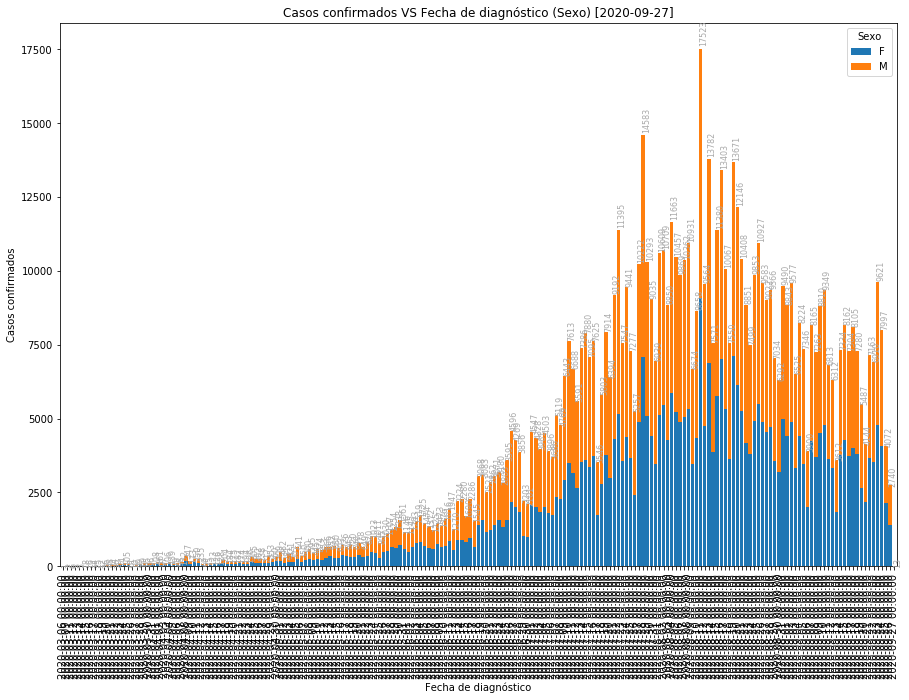

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-27               6.0     7.0
2020-09-26            1394.0  1346.0
2020-09-25            2151.0  1921.0
2020-09-24            4059.0  3938.0
2020-09-23            4772.0  4849.0
2020-09-22            3546.0  3364.0
2020-09-21            3681.0  3482.0
2020-09-20            2176.0  1968.0
2020-09-19            2664.0  2823.0
2020-09-18            3788.0  3492.0
2020-09-17            4014.0  4091.0
2020-09-16            3734.0  3570.0
2020-09-15            4273.0  3889.0
2020-09-14            3752.0  3582.0
2020-09-13            1837.0  1775.0
2020-09-12            3329.0  2983.0
2020-09-11            3625.0  3188.0
2020-09-10            4774.0  4575.0
2020-09-09            4495.0  4315.0
2020-09-08            3705.0  3558.0
2020-09-07            4232.0  3933.0
2020-09-06            1999.0  1901.0
2020-09-05            3470.0  3876.0
2020-09-04            4420.0  3804.0
2020-09-03            3336.0  3189.0
2020-09-02            4887.0  4690.0
2020-09-01            4426.0  4417.0
2020-08-31            5002.0  4488.0
2020-08-30            3189.0  3103.0
2020-08-29            3564.0  3470.0
2020-08-28            4705.0  4661.0
2020-08-27            4553.0  4469.0
2020-08-26            4884.0  4699.0
2020-08-25            5487.0  5440.0
2020-08-24            4913.0  4940.0
2020-08-23            3795.0  3704.0
2020-08-22            4173.0  4678.0
2020-08-21            5249.0  5159.0
2020-08-20            6122.0  6024.0
2020-08-19            7134.0  6537.0
2020-08-18            3646.0  3904.0
2020-08-17            5312.0  4755.0
2020-08-16            7011.0  6392.0
2020-08-15            5773.0  5607.0
2020-08-14            3877.0  3694.0
2020-08-13            6890.0  6892.0
2020-08-12            4741.0  4823.0
2020-08-11            9079.0  8444.0
2020-08-10            4344.0  4314.0
2020-08-09            3446.0  3228.0
2020-08-08            5324.0  5607.0
2020-08-07            5062.0  5300.0
2020-08-06            4887.0  4982.0
2020-08-05            5233.0  5224.0
2020-08-04            5853.0  5810.0
2020-08-03            4280.0  4570.0
2020-08-02            5474.0  5235.0
2020-08-01            5134.0  5475.0
2020-07-31            3473.0  3466.0
2020-07-30            4395.0  4640.0

### - Casos confirmados VS Clasificación de edad (Sexo)

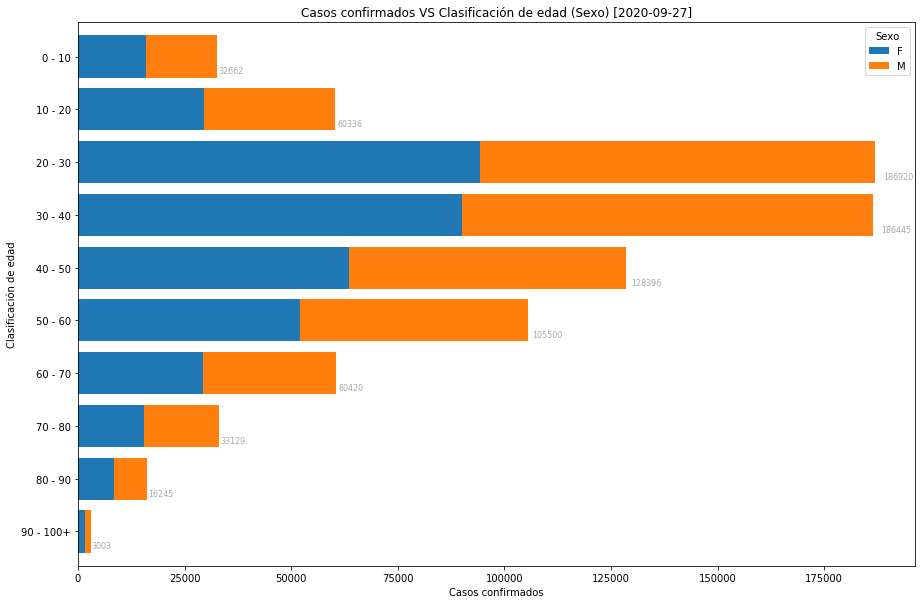

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 15928  16734
10 - 20                29497  30839
20 - 30                94249  92671
30 - 40                90000  96445
40 - 50                63569  64827
50 - 60                51978  53522
60 - 70                29248  31172
70 - 80                15524  17605
80 - 90                 8346   7899
90 - 100+               1693   1310

### - Casos confirmados VS Estado (Sexo)

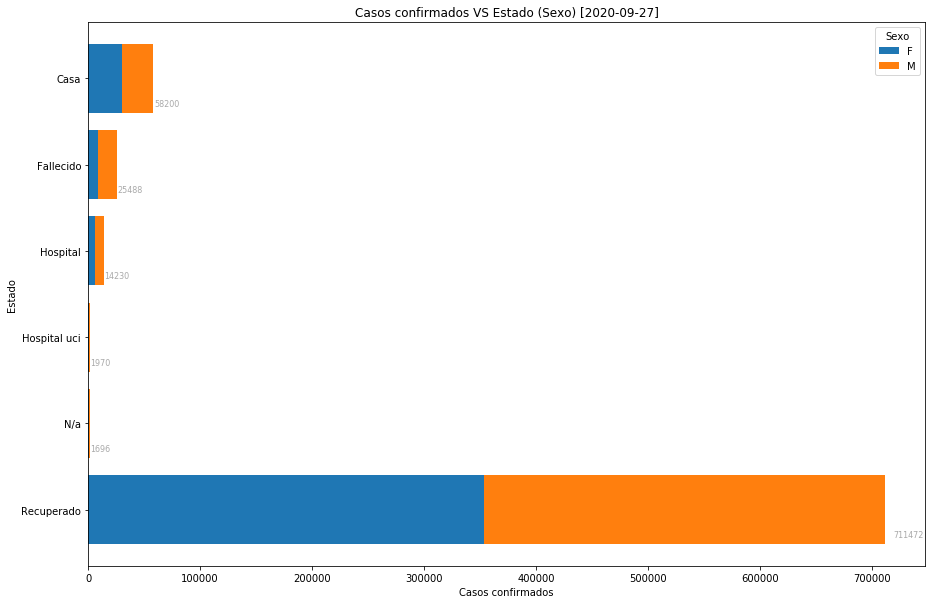

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           29941   28259
Fallecido       9176   16312
Hospital        6134    8096
Hospital uci     663    1307
N/a              734     962
Recuperado    353384  358088

### - Casos confirmados VS Tipo de contagio (Sexo)

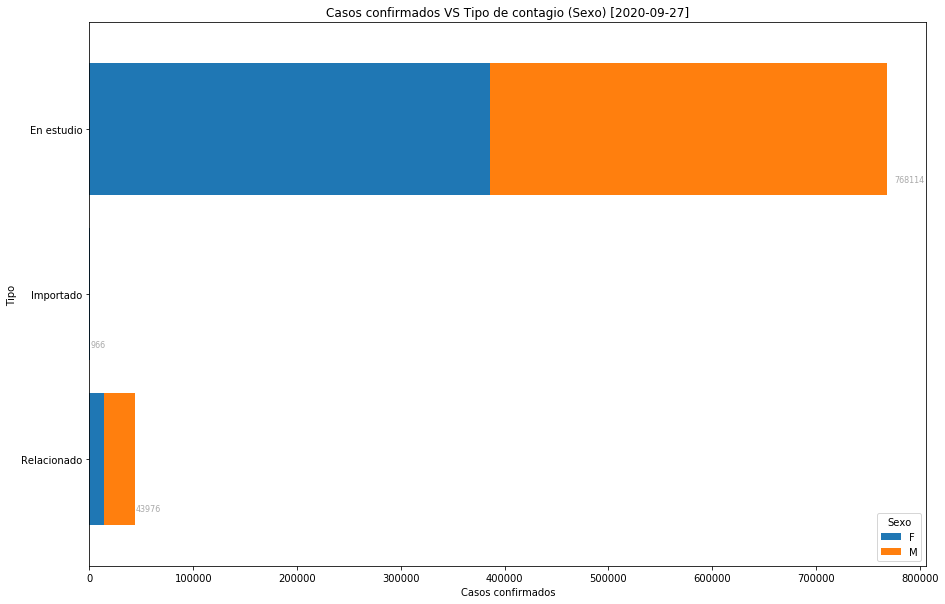

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   385820  382294
Importado       453     513
Relacionado   13759   30217

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

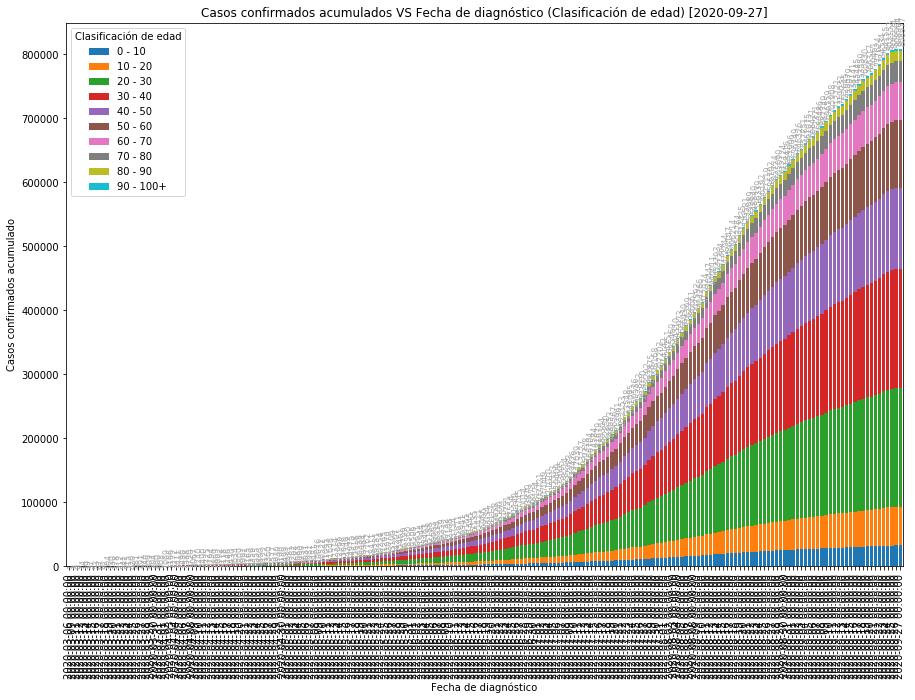

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-27              32521    60044   185923   185456   127796   105005   
2020-09-26              32521    60044   185922   185453   127795   105002   
2020-09-25              32443    59850   185310   184838   127323   104650   
2020-09-24              32322    59569   184290   183978   126674   104088   
2020-09-23              32097    59059   182763   182223   125272   102902   
2020-09-22              31687    58210   180112   180007   124046   101832   
2020-09-21              31390    57679   178509   178523   123027   100984   
2020-09-20              31149    57143   176834   176930   121908   100057   
2020-09-19              30984    56854   175943   176022   121256    99505   
2020-09-18              30768    56407   174693   174839   120442    98765   
2020-09-17              30489    55878   173067   173129   119324    97810   
2020-09-16              30216    55306   171125   171290   118078    96690   
2020-09-15              29922    54791   169448   169629   116903    95718   
2020-09-14              29625    54113   167636   167719   115574    94693   
2020-09-13              29342    53591   165961   165977   114403    93768   
2020-09-12              29207    53351   165091   165114   113854    93302   
2020-09-11              28952    52780   163632   163746   112845    92521   
2020-09-10              28726    52353   162467   162196   111592    91426   
2020-09-09              28345    51631   160083   159977   110266    90296   
2020-09-08              28029    50992   157987   157848   108879    89151   
2020-09-07              27768    50457   156343   156185   107755    88227   
2020-09-06              27461    49852   154504   154373   106431    87153   
2020-09-05              27323    49576   153643   153475   105811    86666   
2020-09-04              27049    48920   151949   151798   104673    85767   
2020-09-03              26723    48395   150031   149923   103382    84675   
2020-09-02              26488    47910   148491   148453   102332    83802   
2020-09-01              26104    47259   146350   146321   100840    82540   
2020-08-31              25759    46564   144306   144301    99473    81380   
2020-08-30              25337    45849   142035   142187    97967    80209   
2020-08-29              25092    45376   140550   140766    96977    79406   
2020-08-28              24837    44844   138908   139222    95878    78449   
2020-08-27              24510    44215   136809   137020    94398    77188   
2020-08-26              24152    43562   134708   134957    92953    76028   
2020-08-25              23799    42844   132641   132774    91407    74826   
2020-08-24              23403    42133   130163   130203    89641    73367   
2020-08-23              23036    41412   127881   127980    88093    72092   
2020-08-22              22725    40804   126096   126237    86982    71103   
2020-08-21              22402    40142   124056   124134    85647    69981   
2020-08-20              21977    39390   121582   121765    84002    68618   
2020-08-19              21490    38528   118914   119037    82075    66995   
2020-08-18              20858    37528   115837   115991    79826    65259   
2020-08-17              20603    37012   114159   114284    78622    64225   
2020-08-16              20087    36248   111927   112163    77015    62876   
2020-08-15              19468    35104   108948   109245    74880    61107   
2020-08-14              18967    34264   106331   106731    73083    59578   
2020-08-13              18712    33720   104595   105049    71863    58511   
2020-08-12              18087    32652   101480   101922    69663    56693   
2020-08-11              17739    32013    99385    99710    68147    55422   
2020-08-10              16928    30747    95248    95659    65308    53170   
2020-08-09            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

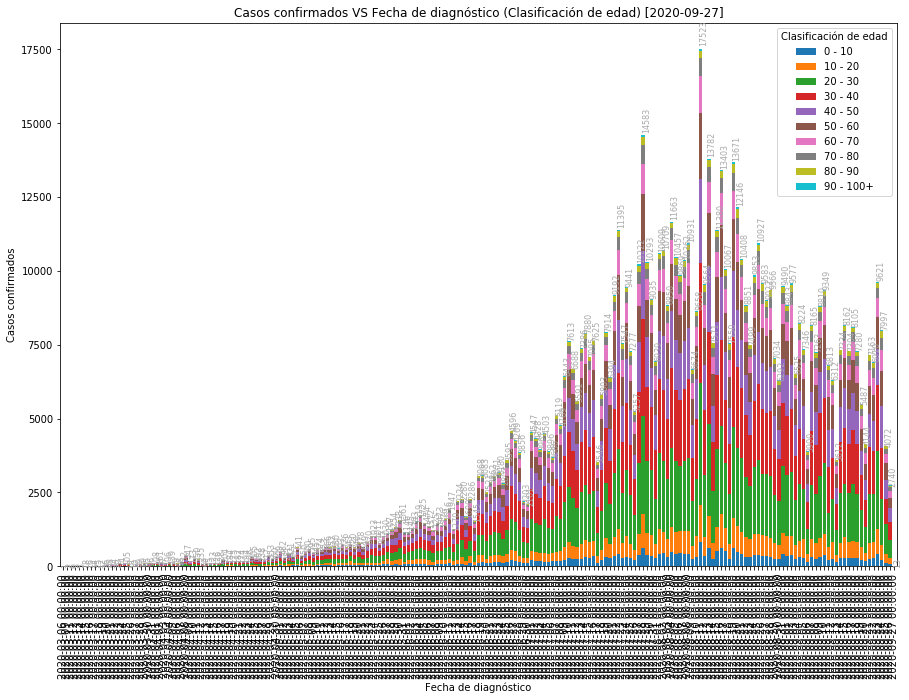

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-27                  0        0        1        3        1        3   
2020-09-26                 78      194      612      615      472      352   
2020-09-25                121      281     1020      860      649      562   
2020-09-24                225      510     1527     1755     1402     1186   
2020-09-23                410      849     2651     2216     1226     1070   
2020-09-22                297      531     1603     1484     1019      848   
2020-09-21                241      536     1675     1593     1119      927   
2020-09-20                165      289      891      908      652      552   
2020-09-19                216      447     1250     1183      814      740   
2020-09-18                279      529     1626     1710     1118      955   
2020-09-17                273      572     1942     1839     1246     1120   
2020-09-16                294      515     1677     1661     1175      972   
2020-09-15                297      678     1812     1910     1329     1025   
2020-09-14                283      522     1675     1742     1171      925   
2020-09-13                135      240      870      863      549      466   
2020-09-12                255      571     1459     1368     1009      781   
2020-09-11                226      427     1165     1550     1253     1095   
2020-09-10                381      722     2384     2219     1326     1130   
2020-09-09                316      639     2096     2129     1387     1145   
2020-09-08                261      535     1644     1663     1124      924   
2020-09-07                307      605     1839     1812     1324     1074   
2020-09-06                138      276      861      898      620      487   
2020-09-05                274      656     1694     1677     1138      899   
2020-09-04                326      525     1918     1875     1291     1092   
2020-09-03                235      485     1540     1470     1050      873   
2020-09-02                384      651     2141     2132     1492     1262   
2020-09-01                345      695     2044     2020     1367     1160   
2020-08-31                422      715     2271     2114     1506     1171   
2020-08-30                245      473     1485     1421      990      803   
2020-08-29                255      532     1642     1544     1099      957   
2020-08-28                327      629     2099     2202     1480     1261   
2020-08-27                358      653     2101     2063     1445     1160   
2020-08-26                353      718     2067     2183     1546     1202   
2020-08-25                396      711     2478     2571     1766     1459   
2020-08-24                367      721     2282     2223     1548     1275   
2020-08-23                311      608     1785     1743     1111      989   
2020-08-22                323      662     2040     2103     1335     1122   
2020-08-21                425      752     2474     2369     1645     1363   
2020-08-20                487      862     2668     2728     1927     1623   
2020-08-19                632     1000     3077     3046     2249     1736   
2020-08-18                255      516     1678     1707     1204     1034   
2020-08-17                516      764     2232     2121     1607     1349   
2020-08-16                619     1144     2979     2918     2135     1769   
2020-08-15                501      840     2617     2514     1797     1529   
2020-08-14                255      544     1736     1682     1220     1067   
2020-08-13                625     1068     3115     3127     2200     1818   
2020-08-12                348      639     2095     2212     1516     1271   
2020-08-11                811     1266     4137     4051     2839     2252   
2020-08-10                330      684     1955     2007     1357     1117   
2020-08-09            

### - Casos confirmados VS Estado (Clasificación de edad)

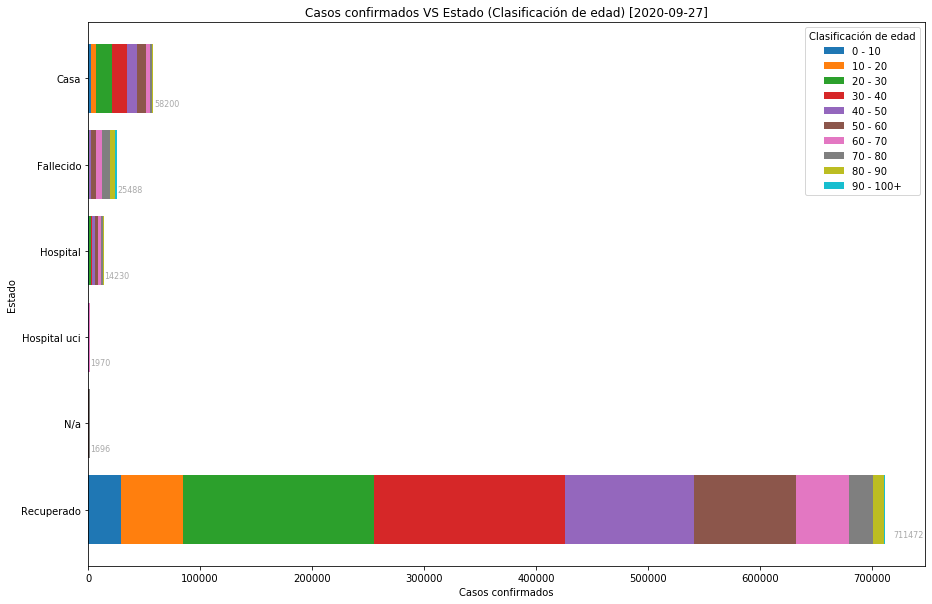

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     2277     4723    14360    13521     9176     7414   
Fallecido                  42       45      323      811     1793     3746   
Hospital                  721      400     1176     1632     1917     2721   
Hospital uci               47       15       74      169      256      475   
N/a                        38       33       69       66      122      202   
Recuperado              29537    55120   170918   170246   115132    90942   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      3902     1870      821        136  
Fallecido                 6097     6590     4924       1117  
Hospital                  2639     1919      962        143  
Hospital uci               499      320      105         10  
N/a                        372      391      329         74  
Recuperado               46911    22039     9104       1523

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

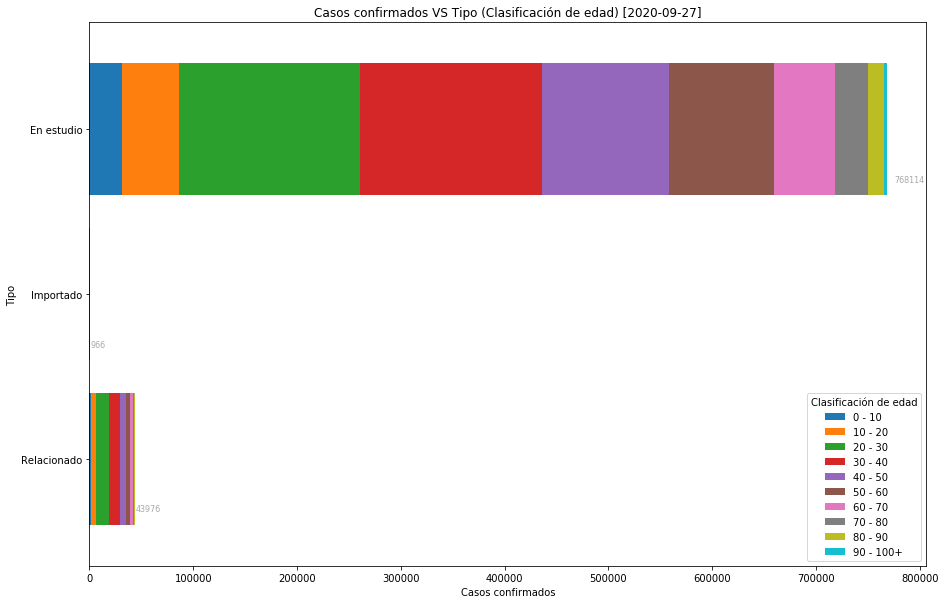

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              31290    55202   174601   174875   122622   101415   
Importado                   7       34      241      225      168      146   
Relacionado              1365     5100    12078    11345     5606     3939   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               58186    31875    15312       2736  
Importado                   97       37       10          1  
Relacionado               2137     1217      923        266

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [47]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)